# GPTChallenge: diagnóstico a partir de HCE

Vamos a trabajar con el corpus CodEsp (textos de historial clínico etiquetados con sus códigos CIE-10 Diagnóstico)

In [2]:
# !unzip DataChallenge.zip

In [3]:
import pandas as pd
import os, re
import numpy as np

pd.options.display.max_colwidth = None

In [4]:
#los códigos están en un TSV con un código por línea
train_diag = pd.read_csv("data/train/train.tsv", sep="\t", header=None, names=["archivo", "codigo"])
train_diag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8316 entries, 0 to 8315
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   archivo  8316 non-null   object
 1   codigo   8316 non-null   object
dtypes: object(2)
memory usage: 130.1+ KB


In [5]:
train_diag['codigo'].value_counts()

codigo
r52       163
r69       150
r50.9     142
i10       116
r59.9      95
         ... 
z56.2       1
f40.00      1
g31.9       1
f41.0       1
d16.9       1
Name: count, Length: 2194, dtype: int64

In [6]:
#cogemos la categoría superior de cada código y las agrupamos
train_diag['cat'] = train_diag['codigo'].str.extract(r'(\w\d\d)')
print(train_diag['cat'].value_counts())
train_diag['cat'].nunique()

cat
r52    163
r10    163
r59    160
r69    150
r50    144
      ... 
s49      1
c47      1
s90      1
r71      1
k61      1
Name: count, Length: 918, dtype: int64


918

In [7]:
categories=train_diag['cat'].value_counts()[:10]
top_categorias = categories.index.to_list()
print(top_categorias)

['r52', 'r10', 'r59', 'r69', 'r50', 'r60', 'i10', 'r11', 'd49', 'n28']


In [8]:
#seleccionamos sólo las etiquetas de este subconjunto
train_diag = train_diag[np.isin(train_diag['cat'], top_categorias)]

In [9]:
#cargamos los dos conjuntos de train
path = 'data/train/text_files/'

corpus = []
for f in [f for f in os.listdir(path) if f.endswith('.txt')]:
    with open(os.path.join(path, f), encoding="utf8") as text:
        texto = text.read()
    #buscamos códigos
    file = f[:-4]
    codigos = train_diag.query('archivo==@file')['cat'].to_list()
    codigos = list(set(codigos))
    if codigos:
        corpus.append({
            'archivo': file,
            'texto': texto,
            'codigos': codigos
        })

df_train = pd.DataFrame(corpus).set_index('archivo')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 562 entries, S0376-78922008000400007-1 to S0211-69952009000600023-1
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   texto    562 non-null    object
 1   codigos  562 non-null    object
dtypes: object(2)
memory usage: 13.2+ KB


In [10]:
df_train.sample(3)

texto  \
archivo                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

## Cargar los textos del conjunto de test

In [11]:
#los códigos están en un TSV con un código por línea
test_diag = pd.read_csv("data/test/test.tsv", sep="\t", header=None, names=['archivo'])
test_diag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   archivo  192 non-null    object
dtypes: object(1)
memory usage: 1.6+ KB


In [12]:
path = 'data/test/text_files/'

# Lista para almacenar los textos y sus códigos correspondientes
corpus = []

# Itera sobre los archivos de texto en el directorio
for f in [f for f in os.listdir(path) if f.endswith('.txt')]:
    with open(os.path.join(path, f), encoding="utf8") as text:
        texto = text.read()

    # Extrae el código del nombre del archivo
    file = f[:-4]

    # Agrega el texto al corpus
    corpus.append({
        'archivo': file,
        'texto': texto
    })

# Crea un DataFrame a partir del corpus
df_test = pd.DataFrame(corpus).set_index('archivo')

In [13]:
df_test.sample(3)

,texto
archivo,
S1130-01082009000400009-1,"Varón de 50 años, diagnosticado de enfermedad de Crohn con afectación ileal y perianal compleja en tratamiento inmunosupresor, que acudió a Urgencias por fiebre, supuración perianal y diarrea de 1 semana de evolución. El enfermo mantenía terapia con salicilatos y azatioprina (2,5 mg/kg/día, ajustada según niveles de TPMT) desde hacía 2 años y había recibido 6 dosis de infliximab, tratamiento biológico que interrumpió 6 meses antes del ingreso actual, por motivos laborales.\nA la exploración física, el paciente impresionaba de mal estado general, estando febril (39 ºC), hipotenso (TA 80/40 mmHg), taquicárdico (104 lpm) y taquipneico (22 rpm). En fosa iliaca derecha se le palpaba un ""efecto masa"", de consistencia aumentada y se objetivaba un orificio fistuloso en glúteo izquierdo sobre un área indurada, eritematosa, caliente y dolorosa. La analítica urgente mostraba anemia (Hb 7,9 g/dl, Hcto 29%), insuficiencia renal (creatinina 4 mg/dl) y elevación de reactantes de fase aguda (PCR 127, plaquetas 424.000/ml). Con el probable diagnóstico de sepsis e insuficiencia renal multifactorial (salicilatos, deshidratación,...) se instauró tratamiento con sueroterapia y antibioterapia de amplio espectro. Durante las siguientes 24 horas, el paciente presentó desorientación, agitación y deterioro de su función renal con evidentes alteraciones metabólicas e hidroelectrolíticas (urea 68 mmol/l, creatinina 6,9 mg/dl, sodio 138 mmol/l, potasio 6 mmol/l, calcio total 7,5 mmol/l, fósforo inorgánico 5,1 mmol/l, LDH 17.481 U/l, urato 44 mg/dl). A la vista de estos resultados, se realizó una ecografia Doppler renal que resultó anodina, interpretándose el fracaso renal como de origen multifactorial agravado por la precipitación de cristales de ácido úrico, para lo que se instauró tratamiento con hiperhidratación, alcalinización de la orina, hemodiálisis, alopurinol y rasburicasa con marcado descenso de los niveles de urato (urato 1,8 mg/dl). No obstante, ante el empeoramiento clínico progresivo del estado general del paciente se realizó un TAC abdominopélvico que demostró una masa retroperitoneal, de 13 x 10 cm y una lesión, en flanco derecho, de 15 x 8,6 cm, que parecía corresponder a un conglomerado de asas fijas con pared engrosada, sin poder descartar una neoplasia subyacente. También se apreciaron múltiples adenopatías en cadena mesentérica, iliacas e inguinales, así como una lesión perirrectal izquierda, en probable relación a su antecedente de absceso y fístula perianal. Esta última lesión era el único hallazgo radiológico objetivado, dos meses antes del episodio actual, en una resonancia abdomino-pélvica de control de su enfermedad perianal.\nA pesar del tratamiento de soporte instaurado, el paciente continuó con fiebre, disminución del nivel de consciencia, disnea progresiva y anuria, falleciendo tres días después de su ingreso en planta. El diagnóstico definitivo fue obtenido tras la realización de una necropsia: plasmocitoma plasmoblástico con predominio de cadenas ligeras tipo lamda que infiltraba íleon terminal y ciego, raíz del mesenterio, ganglios linfáticos abdominales y médula ósea.\n\n"
S0004-06142008000500009-1,"Mujer de 46 años de edad, con antecedente de endometriosis ovárica, a quien se practicó una histerectomía abdominal con doble anexectomía por endometriosis 45 días antes de acudir a consulta, remitida por su ginecólogo por presentar desde el postoperatorio inmediato dolor continuo en región iliaca y sacra derecha que mejoraba con antiinflamatorios y por objetivarse en una ecografía abdominal una discreta ectasia renal. A la exploración la paciente presenta dolor y defensa a la palpación profunda de fosa lumbar derecha y dolorimiento a la percusión y palpación de fosa lumbar izquierda, sugestivo de patología retroperitoneal.\nSe realiza urografía intravenosa (UIV) y Tomografía computerizada (TAC) simultáneos, observándose riñón derecho funcionante con retraso en la captación y elimi

## Binarizar las etiquetas

In [14]:
# para entrenar un clasificador multi-etiqueta generamos una matriz binaria de las etiquetas
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(df_train['codigos'])

#Guardamos las clases utilizadas en el conjunto de train
clases = mlb.classes_
num_classes = clases.shape
print(num_classes[0])

10


## Procesamiento del lenguaje natural

In [15]:
import utils

df_train_clean = utils.clean_corpus(df_train, column_name='texto')
df_test_clean = utils.clean_corpus(df_test, column_name='texto')

In [16]:
# Hacerlo solo la primera vez
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

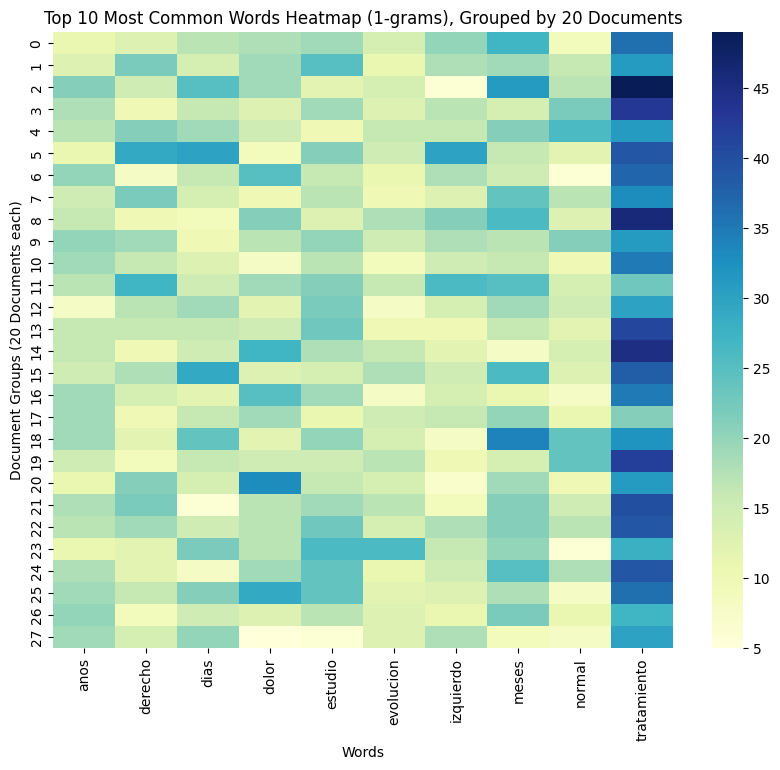

In [17]:
#Hay un vocabulario demasiado grande como para representarlo en una BoW
utils.plot_bow_heatmap(df_train_clean, column_name='texto', n_words=10, n_grams=1)

## Modelos

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


In [19]:
# Vectorizar el texto utilizando TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vectorized = vectorizer.fit_transform(df_train_clean['texto'])

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_vectorized, y_train, test_size=0.2, random_state=42)

In [20]:
model = Pipeline([
    ('clf', OneVsRestClassifier(RandomForestClassifier()))
])

In [21]:
# Entrenar el modelo con los datos de entrenamiento y validar con los datos de validación
model.fit(X_train_split, y_train_split)

# Realizar predicciones en el conjunto de validación
y_val_pred = model.predict(X_val_split)

# Calcular la precisión y F1-score en el conjunto de validación
accuracy_val = accuracy_score(y_val_split, y_val_pred)
f1_val = f1_score(y_val_split, y_val_pred, average='micro')

print("Validation Accuracy:", accuracy_val)
print("Validation F1-score:", f1_val)

Validation Accuracy: 0.061946902654867256
Validation F1-score: 0.28260869565217395


In [22]:
from xgboost import XGBClassifier

In [23]:
model2 = Pipeline([
    ('clf', OneVsRestClassifier(XGBClassifier()))
])

In [24]:
# Entrenar el modelo con los datos de entrenamiento y validar con los datos de validación
model2.fit(X_train_split, y_train_split)

# Realizar predicciones en el conjunto de validación
y_val_pred = model2.predict(X_val_split)

# Calcular la precisión y F1-score en el conjunto de validación
accuracy_val = accuracy_score(y_val_split, y_val_pred)
f1_val = f1_score(y_val_split, y_val_pred, average='micro')

print("Validation Accuracy:", accuracy_val)
print("Validation F1-score:", f1_val)

Validation Accuracy: 0.5221238938053098
Validation F1-score: 0.847682119205298


In [25]:
from sklearn.ensemble import AdaBoostClassifier

In [26]:
model3 = Pipeline([
    ('clf', OneVsRestClassifier(AdaBoostClassifier()))
])

In [27]:
# Entrenar el modelo con los datos de entrenamiento y validar con los datos de validación
model3.fit(X_train_split, y_train_split)

# Realizar predicciones en el conjunto de validación
y_val_pred = model3.predict(X_val_split)

# Calcular la precisión y F1-score en el conjunto de validación
accuracy_val = accuracy_score(y_val_split, y_val_pred)
f1_val = f1_score(y_val_split, y_val_pred, average='micro')

print("Validation Accuracy:", accuracy_val)
print("Validation F1-score:", f1_val)

Validation Accuracy: 0.5132743362831859
Validation F1-score: 0.8366890380313199


### Búsqueda de hiperparámetros

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


In [31]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, f1_score

# Ejemplo de datos de clasificación multietiqueta
X, y = make_multilabel_classification(n_samples=1000, n_features=20, n_classes=5, n_labels=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir el pipeline
pipeline = Pipeline([
    ('clf', OneVsRestClassifier(AdaBoostClassifier()))
])

# Definir los hiperparámetros a buscar
param_grid = {
    'clf__estimator__n_estimators': [370, 375, 380],
    'clf__estimator__learning_rate': [0.01, 0.011]
}

# Definir el objeto GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=make_scorer(f1_score, average='micro'),
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Ajustar el GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train_split, y_train_split)

# Obtener los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Evaluar el mejor modelo en el conjunto de prueba
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val_split)

# Calcular la precisión y F1-score en el conjunto de validación
accuracy_val = accuracy_score(y_val_split, y_val_pred)
f1_val = f1_score(y_val_split, y_val_pred, average='micro')

print("Validation Accuracy:", accuracy_val)
print("Validation F1-score:", f1_val)



Fitting 3 folds for each of 6 candidates, totalling 18 fits
Mejores hiperparámetros: {'clf__estimator__learning_rate': 0.01, 'clf__estimator__n_estimators': 370}
Validation Accuracy: 0.5309734513274337
Validation F1-score: 0.8465116279069769


Mejores hiperparámetros: {'clf__estimator__learning_rate': 0.01, 'clf__estimator__n_estimators': 370}

## Guardar predicciones de Test

In [36]:
y_val_pred

array([[0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])